# Reproduction study - DECAF: Generating Fair Synthetic Data Using Causally-Aware Generative Networks

This notebook can be used to run the experiments as described in our report. Note that this notebook uses pretrained models.

In [1]:
from pyparsing import col
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import statistics
import pickle

from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from util import data, metrics, adult_data, credit_data, plots
from model.DECAF import DECAF

## Experiment 1 - Debiasing Census Data

First, load the adult data, the DAG and the biased edges for different fairness definitions.

In [2]:
dfr, Xy, min_max_scaler = adult_data.load()
X = Xy[:, :-1].astype(float32)
y = np.round(Xy[:, -1]).astype(int)
dm = data.DataModule(Xy)

dag_seed = [
        [0, 6],
        [0, 12],
        [0, 14],
        [0, 1],
        [0, 5],
        [0, 3],
        [1, 14],
        [3, 6],
        [3, 12],
        [3, 14],
        [3, 1],
        [3, 7],
        [5, 6],
        [5, 12],
        [5, 14],
        [5, 1],
        [5, 7],
        [5, 3],
        [6, 14],
        [7, 14],
        [8, 6],
        [8, 14],
        [8, 12],
        [8, 3],
        [8, 5],
        [9, 6],
        [9, 5],
        [9, 14],
        [9, 12],
        [9, 1],
        [9, 3],
        [9, 7],
        [12, 14],
        [13, 5],
        [13, 12],
        [13, 3],
        [13, 1],
        [13, 14],
        [13, 7],
    ]
bias_dict_FTU = {14: [9]}
bias_dict_CF = {14: [7, 9, 5]}
bias_dict_DP = {14: [7, 13, 1, 9, 5, 12, 6]}

                age     workclass        fnlwgt     education  education-num  \
count  30162.000000  30162.000000  3.016200e+04  30162.000000   30162.000000   
mean      38.437902      2.199324  1.897938e+05     10.333764      10.121312   
std       13.134665      0.953925  1.056530e+05      3.812292       2.549995   
min       17.000000      0.000000  1.376900e+04      0.000000       1.000000   
25%       28.000000      2.000000  1.176272e+05      9.000000       9.000000   
50%       37.000000      2.000000  1.784250e+05     11.000000      10.000000   
75%       47.000000      2.000000  2.376285e+05     12.000000      13.000000   
90%       57.000000      4.000000  3.290026e+05     15.000000      13.000000   
95%       62.000000      4.000000  3.796741e+05     15.000000      14.000000   
99%       72.000000      5.000000  5.111542e+05     15.000000      16.000000   
max       90.000000      6.000000  1.484705e+06     15.000000      16.000000   

       marital-status    occupation  re

NameError: name 'float32' is not defined

In [ ]:
DECAF_ND = {
    "precision": [],
    "recall": [],
    "auroc": [],
    "FTU": [],
    "DP": []
}
DECAF_FTU = {
    "precision": [],
    "recall": [],
    "auroc": [],
    "FTU": [],
    "DP": []
}
DECAF_CF = {
    "precision": [],
    "recall": [],
    "auroc": [],
    "FTU": [],
    "DP": []
}
DECAF_DP = {
    "precision": [],
    "recall": [],
    "auroc": [],
    "FTU": [],
    "DP": []
}

def calculate_scores(Xy_synth, fairness_type):
    ## Takes Xy_synthetic data (including label) of the adult data set and fairness type
    ## Calculates the precision, recall, auroc, FTU and DP metrics
    X_synth = Xy_synth[:, :14]
    print("nan in X_synth", np.isnan(X_synth).any())
    y_synth = np.round(Xy_synth[:, 14]).astype(int)
    print("nan in y_synth", np.isnan(y_synth).any())    
    
    synth_clf = MLPClassifier().fit(X_synth, y_synth)
    y_pred_synth = synth_clf.predict(X)
    print("nan in y_pred_synth", np.isnan(y_pred_synth).any())
    y_pred_synth_proba = synth_clf.predict_proba(X)
    print("nan in y_pred_synth_proba", np.isnan(y_pred_synth_proba).any())
    
    if fairness_type == "ND":
        DECAF_ND["precision"].append(precision_score(y, y_pred_synth))
        DECAF_ND["recall"].append(recall_score(y, y_pred_synth))
        DECAF_ND["auroc"].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        DECAF_ND["FTU"].append(metrics.ftu(synth_clf, X_synth, 4))
        DECAF_ND["DP"].append(metrics.dp(synth_clf, X_synth, 4))
    elif fairness_type == "FTU":
        DECAF_FTU["precision"].append(precision_score(y, y_pred_synth))
        DECAF_FTU["recall"].append(recall_score(y, y_pred_synth))
        DECAF_FTU["auroc"].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        DECAF_FTU["FTU"].append(metrics.ftu(synth_clf, X_synth, 4))
        DECAF_FTU["DP"].append(metrics.dp(synth_clf, X_synth, 4))
    elif fairness_type == "CF":
        DECAF_CF["precision"].append(precision_score(y, y_pred_synth))
        DECAF_CF["recall"].append(recall_score(y, y_pred_synth))
        DECAF_CF["auroc"].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        DECAF_CF["FTU"].append(metrics.ftu(synth_clf, X_synth, 4))
        DECAF_CF["DP"].append(metrics.dp(synth_clf, X_synth, 4))    
    elif fairness_type == "DP":
        DECAF_DP["precision"].append(precision_score(y, y_pred_synth))
        print("precision done")
        DECAF_DP["recall"].append(recall_score(y, y_pred_synth))
        print("recall done")
        DECAF_DP["auroc"].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        print("auroc done")
        DECAF_DP["FTU"].append(metrics.ftu(synth_clf, X_synth, 4))
        print("ftu done")
        DECAF_DP["DP"].append(metrics.dp(synth_clf, X_synth, 4))
        print("dp done")
    else:
        print("Warning: fairness_type not recognized")
    return

If you would like to generate the synthetic data from the pre-trained models yourself, run the cell below. This will take approximately 1 hour for the 10 models (UPDATE THIS NUMBER). Otherwise, run the second cell.

In [ ]:
# Run if you want to generate synthetic data yourself. Otherwise, skip this cell.

# models = ["logs/DECAF_adult/version_0/checkpoints/epoch=49-step=21249.ckpt","logs/DECAF_adult/version_1/checkpoints/epoch=49-step=21249.ckpt" ]
models = ["logs/DECAF_adult/version_2/checkpoints/epoch=49-step=21249.ckpt", "logs/DECAF_adult/version_4/checkpoints/epoch=49-step=21249.ckpt"] # to be added
# only version 1 & 3 has error

data_all_models = [] # delete if file generated date already exists

for trained_model in models:
    model = DECAF(input_dim=dm.dims[0])    
    model = model.load_from_checkpoint(trained_model)
    
    synthetic_data = model.gen_synthetic(dm.dataset.x, gen_order=model.get_gen_order(), biased_edges={}).detach().numpy()
    calculate_scores(synthetic_data, fairness_type="ND")
    
    synthetic_data_FTU = model.gen_synthetic(dm.dataset.x, gen_order=model.get_gen_order(), biased_edges=bias_dict_FTU).detach().numpy()
    calculate_scores(synthetic_data_FTU, fairness_type="FTU")
    
    synthetic_data_CF = model.gen_synthetic(dm.dataset.x, gen_order=model.get_gen_order(), biased_edges=bias_dict_CF).detach().numpy()
    calculate_scores(synthetic_data_CF, fairness_type="CF")
    
    synthetic_data_DP = model.gen_synthetic(dm.dataset.x, gen_order=model.get_gen_order(), biased_edges=bias_dict_DP).detach().numpy()    
    calculate_scores(synthetic_data_DP, fairness_type="DP")
    
#     synthetic_data_to_store = {}        
#     synthetic_data_to_store["synthetic_data"] = synthetic_data
#     synthetic_data_to_store["synthetic_data_FTU"] = synthetic_data_FTU
#     synthetic_data_to_store["synthetic_data_CF"] = synthetic_data_CF
#     synthetic_data_to_store["synthetic_data_DP"] = synthetic_data_DP
    
#     data_all_models.append(synthetic_data_to_store)
    
# with open('synthetic_data.pkl', 'wb') as f:
#     pickle.dump(data_all_models, f)


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0.

In [41]:
# Run if you want to use pre-generated synthetic data

with open('synthetic_data.pkl', 'rb') as f:
    all_syn_data = pickle.load(f)

for synthetic_data_stored in all_syn_data:
    synthetic_data = synthetic_data_stored["synthetic_data"]
    calculate_scores(synthetic_data, fairness_type="ND")
    synthetic_data_FTU = synthetic_data_stored["synthetic_data_FTU"]
    calculate_scores(synthetic_data_FTU, fairness_type="FTU")
    synthetic_data_CF = synthetic_data_stored["synthetic_data_CF"]
    calculate_scores(synthetic_data_CF, fairness_type="CF")
    synthetic_data_DP = synthetic_data_stored["synthetic_data_DP"]
    calculate_scores(synthetic_data_DP, fairness_type="DP")


In [40]:
def calc_metrics(data):
    # Calculate mean and stdev of the data, returns a string
    mean = statistics.mean(data)
    stdev = statistics.stdev(data, mean)
    return "{:.3f}±{:.3f}".format(mean, stdev)
    
d = [ ["Original Data", 0 ,0,0,0,0],
     ["GAN", 0 ,0,0,0,0],
     ["WGAN-GP", 0 ,0,0,0,0],
     ["GAN-PR", 0 ,0,0,0,0],
     ["WGAN-GP-PR", 0 ,0,0,0,0],
     ["DECAF-ND", calc_metrics(DECAF_ND["precision"]), calc_metrics(DECAF_ND["recall"]), calc_metrics(DECAF_ND["auroc"]), calc_metrics(DECAF_ND["FTU"]), calc_metrics(DECAF_ND["DP"])],
     ["DECAF-FTU", calc_metrics(DECAF_FTU["precision"]), calc_metrics(DECAF_FTU["recall"]), calc_metrics(DECAF_FTU["auroc"]), calc_metrics(DECAF_FTU["FTU"]), calc_metrics(DECAF_FTU["DP"])],
     ["DECAF-CF", calc_metrics(DECAF_CF["precision"]), calc_metrics(DECAF_CF["recall"]), calc_metrics(DECAF_CF["auroc"]), calc_metrics(DECAF_CF["FTU"]), calc_metrics(DECAF_CF["DP"])],
     ["DECAF-DP", calc_metrics(DECAF_DP["precision"]), calc_metrics(DECAF_DP["recall"]), calc_metrics(DECAF_DP["auroc"]), calc_metrics(DECAF_DP["FTU"]), calc_metrics(DECAF_DP["DP"])]
]

df = pd.DataFrame(d, columns = ["Model", "Precision", "Recall", "AUROC", "FTU", "DP"])
df

TypeError: don't know how to coerce float32 and float64

## Experiment 2 - Fair Credit Approval

First, load the credit data, the DAG and the biased edges for different fairness definitions of the credit data.

In [3]:
dfr, Xy, min_max_scaler = credit_data.load(0.5)
dm = data.DataModule(Xy)
X = Xy[:, :-1].astype("float32")
y = np.round(Xy[:, -1]).astype(int)

dag_seed = [[1, 7], [7, 10], [10, 2], [10, 15], [2, 14], [14, 15], [14, 3], [3, 15], [13, 3], [12, 3], [6, 3], [6, 15], [5, 3], [5, 9], [9, 2], [9, 15], [9, 4], [9, 12], [11, 9], [8, 10], [8, 15], [8, 9]]
bias_dict_credit_FTU = {15: [6]}
bias_dict_credit_DP = {15: [6, 3]}

n = 6
betas = np.linspace(0, 1, n, endpoint=True)

In [9]:
DECAF_Credit_ND = {
    "Precision": [[]] * len(betas),
    "Recall": [[]] * len(betas),
    "AUROC": [[]] * len(betas),
    "FTU": [[]] * len(betas),
    "DP": [[]] * len(betas)
}
DECAF_Credit_FTU = {
    "Precision": [[]] * len(betas),
    "Recall": [[]] * len(betas),
    "AUROC": [[]] * len(betas),
    "FTU": [[]] * len(betas),
    "DP": [[]] * len(betas)
}
DECAF_Credit_DP = {
    "Precision": [[]] * len(betas),
    "Recall": [[]] * len(betas),
    "AUROC": [[]] * len(betas),
    "FTU": [[]] * len(betas),
    "DP": [[]] * len(betas)
}

In [8]:
def calculate_scores_credit(Xy_synth, fairness_type, beta_idx):
    ## Takes Xy_synthetic data (including label) of the adult data set and fairness type
    ## Calculates the precision, recall, auroc, FTU and DP metrics
    X_synth = Xy_synth[:, :-1]
    y_synth = np.round(Xy_synth[:, -1]).astype(int)   
    
    synth_clf = MLPClassifier().fit(X_synth, y_synth)
    y_pred_synth = synth_clf.predict(X)
    y_pred_synth_proba = synth_clf.predict_proba(X)
    print(beta_idx)
    
    if fairness_type == "ND":
        print(beta_idx)
        print(DECAF_Credit_ND["Precision"][0])
        print(DECAF_Credit_ND["Precision"][1])
        DECAF_Credit_ND["Precision"][beta_idx].append(precision_score(y, y_pred_synth))
        DECAF_Credit_ND["Recall"][beta_idx].append(recall_score(y, y_pred_synth))
        DECAF_Credit_ND["AUROC"][beta_idx].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        DECAF_Credit_ND["FTU"][beta_idx].append(metrics.ftu(synth_clf, X_synth, 6))
        DECAF_Credit_ND["DP"][beta_idx].append(metrics.dp(synth_clf, X_synth, 6))
    elif fairness_type == "FTU":
        DECAF_Credit_FTU["Precision"][beta_idx].append(precision_score(y, y_pred_synth))
        DECAF_Credit_FTU["Recall"][beta_idx].append(recall_score(y, y_pred_synth))
        DECAF_Credit_FTU["AUROC"][beta_idx].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        DECAF_Credit_FTU["FTU"][beta_idx].append(metrics.ftu(synth_clf, X_synth, 6))
        DECAF_Credit_FTU["DP"][beta_idx].append(metrics.dp(synth_clf, X_synth, 6))  
    elif fairness_type == "DP":
        DECAF_Credit_DP["Precision"][beta_idx].append(precision_score(y, y_pred_synth))
        print("precision done")
        DECAF_Credit_DP["Recall"][beta_idx].append(recall_score(y, y_pred_synth))
        print("recall done")
        DECAF_Credit_DP["AUROC"][beta_idx].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        print("auroc done")
        DECAF_Credit_DP["FTU"][beta_idx].append(metrics.ftu(synth_clf, X_synth, 6))
        print("ftu done")
        DECAF_Credit_DP["DP"][beta_idx].append(metrics.dp(synth_clf, X_synth, 6))
        print("dp done")
    else:
        print("Warning: fairness_type not recognized")
    return

In [10]:
for idx, beta in enumerate(betas):
    models = []
    for i in range(10):
        models.append("logs/DECAF_credit{}/version_{}/checkpoints/epoch=249-step=2499.ckpt".format(beta, i)) # to be added

    for trained_model in models:
        model = DECAF(input_dim=dm.dims[0])    
        model = model.load_from_checkpoint(trained_model)

        synthetic_data = model.gen_synthetic(dm.dataset.x, gen_order=model.get_gen_order(), biased_edges={}).detach().numpy()
        calculate_scores_credit(synthetic_data, fairness_type="ND", beta_idx=idx)

        synthetic_data_FTU = model.gen_synthetic(dm.dataset.x, gen_order=model.get_gen_order(), biased_edges=bias_dict_credit_FTU).detach().numpy()
        calculate_scores_credit(synthetic_data_FTU, fairness_type="FTU", beta_idx=idx)

        synthetic_data_DP = model.gen_synthetic(dm.dataset.x, gen_order=model.get_gen_order(), biased_edges=bias_dict_credit_DP).detach().numpy()    
        calculate_scores_credit(synthetic_data_DP, fairness_type="DP", beta_idx=idx)

Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
[]
[]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
[0.926605504587156]
[0.926605504587156]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
[0.926605504587156, 0.8784530386740331]
[0.926605504587156, 0.8784530386740331]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
[0.926605504587156, 0.8784530386740331, 0.8911174785100286]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945]


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634, 0.9316770186335404]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634, 0.9316770186335404, 0.9202453987730062]
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634, 0.9316770186335404, 0.9202453987730062, 0.8931750741839762]
[0.926605504587156, 0.8784530386740331, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634, 0.9316770186335404, 0.9202453987730062, 0.8931750741839762, 0.9371069182389937]
[0.926605504587156, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634, 0.9316770186335404, 0.9202453987730062, 0.8931750741839762, 0.9371069182389937, 0.9202453987730062]
[

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634, 0.9316770186335404, 0.9202453987730062, 0.8931750741839762, 0.9371069182389937, 0.9202453987730062, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634, 0.9316770186335404, 0.9202453987730062, 0.8931750741839762, 0.9371069182389937, 0.9202453987730062, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634, 0.9316770186335404, 0.9202453987730062, 0.8931750741839762, 0.9371069182389937, 0.9202453987730062, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634, 0.9316770186335404, 0.9202453987730062, 0.8931750741839762, 0.9371069182389937, 0.9202453987730062, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634, 0.9316770186335404, 0.9202453987730062, 0.8931750741839762, 0.9371069182389937, 0.9202453987730062, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634, 0.9316770186335404, 0.9202453987730062, 0.8931750741839762, 0.9371069182389937, 0.9202453987730062, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634, 0.9316770186335404, 0.9202453987730062, 0.8931750741839762, 0.9371069182389937, 0.9202453987730062, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634, 0.9316770186335404, 0.9202453987730062, 0.8931750741839762, 0.9371069182389937, 0.9202453987730062, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
precision done
recall done
auroc done
ftu done
dp done
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
[0.926605504587156, 0.8784530386740331, 0.8911174785100286, 0.9159159159159159, 0.9259259259259259, 0.9129129129129129, 0.9233128834355828, 0.9146341463414634, 0.9093655589123867, 0.9287925696594427, 0.8950437317784257, 0.9287925696594427, 0.9077380952380952, 0.9202453987730062, 0.9202453987730062, 0.9093655589123867, 0.9230769230769231, 0.9147058823529411, 0.9259259259259259, 0.863013698630137, 0.9230769230769231, 0.8677685950413223, 0.9230769230769231, 0.9093655589123867, 0.908256880733945, 0.9259259259259259, 0.9202453987730062, 0.9072463768115943, 0.893491124260355, 0.9181818181818182, 0.9202453987730062, 0.9146341463414634, 0.9316770186335404, 0.8924418604651163, 0.9230769230769231, 0.9230769230769231, 0.9129129129129129, 0.9316770186335404, 0.9207317073170732, 0.8739495798319328, 0.9259259259259259, 0.8853868194842407, 0.9316770186335404, 0.9213483146067416, 0.9146341463414634, 0.9316770186335404, 0.9202453987730062, 0.8931750741839762, 0.9371069182389937, 0.9202453987730062, 0

C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5
5
precision done
recall done
auroc done
ftu done
dp done


C:\Users\zoepr\anaconda3\envs\decaf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


60
[0.9151673791453359, 0.9151673791453359, 0.9151673791453359, 0.9151673791453359, 0.9151673791453359, 0.9151673791453359] [0.015276862193247321, 0.015276862193247321, 0.015276862193247321, 0.015276862193247321, 0.015276862193247321, 0.015276862193247321]


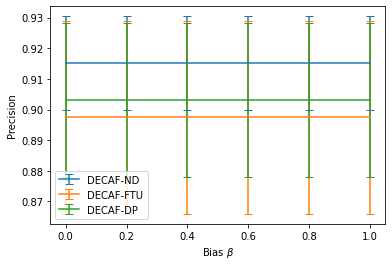

[0.8092940125111707, 0.8092940125111707, 0.8092940125111707, 0.8092940125111707, 0.8092940125111707, 0.8092940125111707] [0.010987208882900903, 0.010987208882900903, 0.010987208882900903, 0.010987208882900903, 0.010987208882900903, 0.010987208882900903]


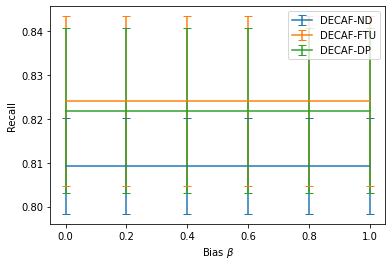

[0.8803244993334213, 0.8803244993334213, 0.8803244993334213, 0.8803244993334213, 0.8803244993334213, 0.8803244993334213] [0.014576115195640107, 0.014576115195640107, 0.014576115195640107, 0.014576115195640107, 0.014576115195640107, 0.014576115195640107]


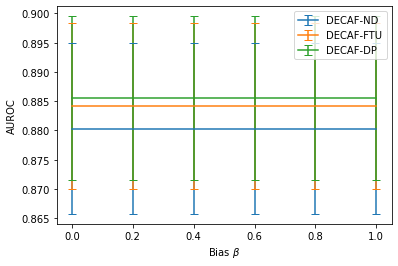

AssertionError: 

In [7]:
print(len(DECAF_Credit_ND["Precision"][0]))
for metric in ["Precision", "Recall", "AUROC", "FTU", "DP"]:
    means_ND = [statistics.mean(data) for data in DECAF_Credit_ND[metric]]
    stds_ND = []
    for i, mean in enumerate(means_ND):
        stds_ND.append(statistics.stdev(DECAF_Credit_ND[metric][i], mean))
    means_FTU = [statistics.mean(data) for data in DECAF_Credit_FTU[metric]]
    stds_FTU = []
    for i, mean in enumerate(means_FTU):
        stds_FTU.append(statistics.stdev(DECAF_Credit_FTU[metric][i], mean))
    means_DP = [statistics.mean(data) for data in DECAF_Credit_DP[metric]]
    stds_DP = []
    for i, mean in enumerate(means_DP):
        stds_DP.append(statistics.stdev(DECAF_Credit_DP[metric][i], mean))
    print(means_ND, stds_ND)
    results = {"DECAF-ND": list(zip(means_ND, stds_ND)),
                "DECAF-FTU": list(zip(means_FTU, stds_FTU)),
                "DECAF-DP": list(zip(means_DP, stds_DP))}
    plots.plot_errorbar(betas, metric, results)